In [1]:
using Statistics
using CSV
using DataFrames
using Measures
using Gadfly

ENV["LINES"] = 9;

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\Diego\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


In [2]:
# parameters
protein = "TPM1"

"TPM1"

In [3]:
function path_to_TranscriptAnnotation()
    folders = String[]
    for folder in splitpath(pwd())
        push!(folders, folder)
        if folder == "TranscriptAnnotation"
            break
        end
    end
    joinpath(folders...)
end

results_folder = joinpath(path_to_TranscriptAnnotation(), "benchmark", protein)
table_path = joinpath(results_folder, "thoraxe", "homologous_exon_table.csv")

const table = CSV.read(table_path);

## Transcripts per species

In [4]:
by(table, :Species, :TranscriptIDCluster => length ∘ unique) |> 
    df -> rename!(df, :TranscriptIDCluster_function => :Transcripts) |>
    df -> show(df, allcols=true, allrows=true)

10×2 DataFrame
│ Row │ Species                  │ Transcripts │
│     │ String                   │ Int64       │
├─────┼──────────────────────────┼─────────────┤
│ 1   │ bos_taurus               │ 7           │
│ 2   │ homo_sapiens             │ 16          │
│ 3   │ gorilla_gorilla          │ 10          │
│ 4   │ macaca_mulatta           │ 10          │
│ 5   │ monodelphis_domestica    │ 1           │
│ 6   │ mus_musculus             │ 9           │
│ 7   │ ornithorhynchus_anatinus │ 1           │
│ 8   │ rattus_norvegicus        │ 8           │
│ 9   │ sus_scrofa               │ 8           │
│ 10  │ xenopus_tropicalis       │ 2           │

## (Sub)exons without (known) homology

In [5]:
total = sum(startswith(exonid, "0_") for exonid in unique(table[:HomologousExon]))
print("Number of (sub)exons without (known) homology in the gene: ", total)

Number of (sub)exons without (known) homology in the gene: 31

In [6]:
by(table, :Species) do df
    (ExonsWithoutHomology = sum(startswith(exonid, "0_") for exonid in unique(df[:HomologousExon])), )
end |> df -> show(df, allcols=true, allrows=true)

10×2 DataFrame
│ Row │ Species                  │ ExonsWithoutHomology │
│     │ String                   │ Int64                │
├─────┼──────────────────────────┼──────────────────────┤
│ 1   │ bos_taurus               │ 5                    │
│ 2   │ homo_sapiens             │ 6                    │
│ 3   │ gorilla_gorilla          │ 4                    │
│ 4   │ macaca_mulatta           │ 1                    │
│ 5   │ monodelphis_domestica    │ 1                    │
│ 6   │ mus_musculus             │ 3                    │
│ 7   │ ornithorhynchus_anatinus │ 0                    │
│ 8   │ rattus_norvegicus        │ 2                    │
│ 9   │ sus_scrofa               │ 8                    │
│ 10  │ xenopus_tropicalis       │ 1                    │

### Short exons

Some subexons doesn't have known homologs because they are too short

In [7]:
by(table, [:TranscriptIDCluster, :ExonIDCluster], :SubexonProteinSequence => join) |>
    df -> by(df, 
        :ExonIDCluster, 
        :SubexonProteinSequence_join => col -> minimum(map(x -> length(replace(x, "*" => "")), col))) |>
    df -> rename!(df, :SubexonProteinSequence_join_function => :ExonLength) |>
    df -> df[df[:ExonLength] .≤ 4, :] |>
    df -> show(df, allcols=true, allrows=true)

11×2 DataFrame
│ Row │ ExonIDCluster                         │ ExonLength │
│     │ String                                │ Int64      │
├─────┼───────────────────────────────────────┼────────────┤
│ 1   │ ENSBTAE00000282467/ENSBTAE00000496525 │ 0          │
│ 2   │ ENSE00002555985/ENSE00003822966       │ 0          │
│ 3   │ ENSGGOE00000366573                    │ 0          │
│ 4   │ ENSMMUE00000355333                    │ 4          │
│ 5   │ ENSMMUE00000423566                    │ 0          │
│ 6   │ ENSMODE00000304032                    │ 0          │
│ 7   │ ENSMUSE00000696677                    │ 0          │
│ 8   │ ENSRNOE00000493327                    │ 0          │
│ 9   │ ENSRNOE00000545052                    │ 3          │
│ 10  │ ENSSSCE00000278196                    │ 0          │
│ 11  │ ENSXETE00000400339                    │ 0          │

## Putative orthologous exons

In [8]:
total = sum(!startswith(exonid, "0_") for exonid in unique(table[:HomologousExon]))
print("Number of putative orthologous exons in the gene: ", total)

Number of putative orthologous exons in the gene: 30

In [9]:
by(table, :Species) do df
    (ExonsWithoutHomology = sum(!startswith(exonid, "0_") for exonid in unique(df[:HomologousExon])), )
end |> df -> show(df, allcols=true, allrows=true)

10×2 DataFrame
│ Row │ Species                  │ ExonsWithoutHomology │
│     │ String                   │ Int64                │
├─────┼──────────────────────────┼──────────────────────┤
│ 1   │ bos_taurus               │ 17                   │
│ 2   │ homo_sapiens             │ 18                   │
│ 3   │ gorilla_gorilla          │ 25                   │
│ 4   │ macaca_mulatta           │ 24                   │
│ 5   │ monodelphis_domestica    │ 10                   │
│ 6   │ mus_musculus             │ 16                   │
│ 7   │ ornithorhynchus_anatinus │ 8                    │
│ 8   │ rattus_norvegicus        │ 19                   │
│ 9   │ sus_scrofa               │ 19                   │
│ 10  │ xenopus_tropicalis       │ 14                   │

## Exon Lengths

Distribution of homologous exon lengths

In [10]:
len(x) = ismissing(x) ? 0 : length(x)

const lengths = by(table, :HomologousExon, :HomologousExonSequence => col -> maximum(len.(col))) |> 
    df -> rename!(df, :HomologousExonSequence_function  => :HomologousExonLength ) |>
    df -> sort!(df, :HomologousExon) 

show(lengths, allrows=true)

61×2 DataFrame
│ Row │ HomologousExon │ HomologousExonLength │
│     │ String         │ Int64                │
├─────┼────────────────┼──────────────────────┤
│ 1   │ 0_1            │ 0                    │
│ 2   │ 0_10           │ 0                    │
│ 3   │ 0_11           │ 26                   │
│ 4   │ 0_12           │ 0                    │
│ 5   │ 0_13           │ 17                   │
│ 6   │ 0_14           │ 0                    │
│ 7   │ 0_15           │ 0                    │
│ 8   │ 0_16           │ 0                    │
│ 9   │ 0_17           │ 0                    │
│ 10  │ 0_18           │ 0                    │
│ 11  │ 0_19           │ 0                    │
│ 12  │ 0_2            │ 0                    │
│ 13  │ 0_20           │ 0                    │
│ 14  │ 0_21           │ 0                    │
│ 15  │ 0_22           │ 3                    │
│ 16  │ 0_23           │ 17                   │
│ 17  │ 0_24           │ 17                   │
│ 18  │ 0_25           │ 

In [11]:
lengths[:WithHomologous] = [ !startswith(exonid, "0_") for exonid in lengths[:HomologousExon ] ];

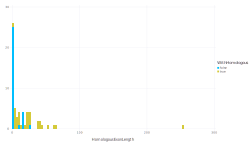

In [12]:
plt = plot(lengths, x="HomologousExonLength", color="WithHomologous", Geom.histogram)
draw(SVG(25cm, 15cm), plt)

## Alternative spliced homologous exons

Exons with a `TranscriptFraction` of `1.0` in a gene are constitutive. The plot can help to identify homologous_exons that change their `TranscriptFraction` in different genes.

In [13]:
constitutive = by(table, :GeneID) do df
    subdf = unique(df[:, [:HomologousExon, :TranscriptsWithSubexon, :TranscriptsInGene]])
    by(subdf, :HomologousExon) do exondf
        (TranscriptFraction = exondf[1, :TranscriptsWithSubexon] / exondf[1, :TranscriptsInGene],
         TranscriptsWithSubexon = exondf[1, :TranscriptsWithSubexon],
         TranscriptsInGene = exondf[1, :TranscriptsInGene])
    end
end;

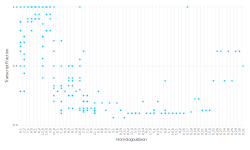

In [14]:
plt = plot(constitutive, x="HomologousExon", y="TranscriptFraction", Geom.point)
draw(SVG(25cm, 15cm), plt)

In [15]:
show(constitutive, allrows=true, allcols=true)

201×5 DataFrame
│ Row │ GeneID             │ HomologousExon │ TranscriptFraction │
│     │ String             │ String         │ Float64            │
├─────┼────────────────────┼────────────────┼────────────────────┤
│ 1   │ ENSBTAG00000005373 │ 6_1            │ 0.285714           │
│ 2   │ ENSBTAG00000005373 │ 2_2            │ 0.285714           │
│ 3   │ ENSBTAG00000005373 │ 7_1            │ 1.0                │
│ 4   │ ENSBTAG00000005373 │ 8_0            │ 1.0                │
│ 5   │ ENSBTAG00000005373 │ 8_1            │ 1.0                │
│ 6   │ ENSBTAG00000005373 │ 6_2            │ 1.0                │
│ 7   │ ENSBTAG00000005373 │ 12_0           │ 0.857143           │
│ 8   │ ENSBTAG00000005373 │ 14_0           │ 1.0                │
│ 9   │ ENSBTAG00000005373 │ 3_0            │ 1.0                │
│ 10  │ ENSBTAG00000005373 │ 11_0           │ 0.714286           │
│ 11  │ ENSBTAG00000005373 │ 0_1            │ 0.285714           │
│ 12  │ ENSBTAG00000005373 │ 1_0            │ 